# CS M148 Final Project: Spotify Music Track Analysis

**Team Project — Complete Analysis Notebook**

---

This notebook combines all project analyses into a single cohesive document:

1. **Part 1**: Dataset Description, Features, Data Cleaning & EDA
2. **Part 2**: Linear & Logistic Regression for Danceability Prediction
3. **Part 3**: KNN, Random Forest, PCA & Clustering
4. **Part 4**: Neural Network Classification

---

In [ ]:
# =============================================================================
# IMPORTS
# =============================================================================

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import io
import gc
import itertools

# Scikit-learn: Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer

# Scikit-learn: Model Selection
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Scikit-learn: Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Scikit-learn: Metrics
from sklearn.metrics import (
    mean_squared_error, r2_score, accuracy_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report,
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    ConfusionMatrixDisplay
)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Suppress warnings
warnings.filterwarnings('ignore')

# Display and plotting defaults
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 200)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"TensorFlow version: {tf.__version__}")
print("All libraries imported successfully!")


---

# Part 1: Project Check-In 1 — Dataset & EDA

---

# CS M148 Project Check-in 1

**Project**: Spotify Music Track Analysis and Classification

**Date**: December 12, 2025

---

## Table of Contents
1. Dataset Description
2. Main Features and Justification
3. Data Cleaning and Missingness Handling
4. Exploratory Data Analysis (EDA)


---

## 1. Dataset Description

### What Dataset Did We Choose?

Our team has chosen the **Spotify Tracks Dataset** from Hugging Face, which is publicly available and contains comprehensive audio feature data for over 114,000 music tracks across multiple genres.

**Dataset Source**: [Hugging Face - maharshipandya/spotify-tracks-dataset](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset)

### Dataset Overview:
- **Total Tracks**: ~114,000 songs
- **Features**: 21 columns including audio characteristics and metadata
- **Genres**: 114 different music genres (rock, pop, classical, jazz, hip-hop, electronic, etc.)
- **Audio Features**: Quantitative measurements from Spotify's Audio Analysis API

### Why This Dataset?

We selected this dataset for several compelling reasons:

1. **Rich Feature Set**: The dataset includes detailed audio analysis metrics (danceability, energy, valence, tempo, etc.) that provide deep insights into musical characteristics.

2. **Large Sample Size**: With 114,000+ tracks, we have sufficient data for robust machine learning models and statistical analysis.

3. **Multi-Genre Coverage**: 114 distinct genres allow us to explore how different musical styles differ in their acoustic properties.

4. **Real-World Application**: Music recommendation systems and playlist generation are valuable commercial applications, making this project practically relevant.

5. **Balanced Classes**: Each genre contains approximately 1,000 tracks, providing good class balance for classification tasks.

6. **Data Quality**: The dataset is sourced from Spotify's official API, ensuring professional-grade measurements.

### Research Questions We Can Explore:
- Can we predict a song's genre based on its audio features?
- What features most strongly influence a song's danceability?
- Are there clusters of similar songs across different genres?
- How do audio characteristics vary across different music genres?


In [ ]:
# Load the dataset from Hugging Face
url = "https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset/resolve/main/dataset.csv"
print("Downloading Spotify dataset from Hugging Face...")
response = requests.get(url, timeout=30)
response.raise_for_status()
df_original = pd.read_csv(io.StringIO(response.text))
print("✓ Dataset loaded successfully!\n")

# Display basic information
print(f"Dataset shape: {df_original.shape}")
print(f"Number of tracks: {df_original.shape[0]:,}")
print(f"Number of features: {df_original.shape[1]}\n")

# Show first few rows
print("First 5 rows of the dataset:")
df_original.head()


In [ ]:
# Display column information
print("Dataset Columns and Data Types:\n")
print(df_original.dtypes)
print("\n" + "="*60)
print("Dataset Summary Statistics:")
df_original.describe()


---

## 2. Main Features in the Data

### Audio Feature Descriptions

Our analysis focuses on the following audio features provided by Spotify's Audio Analysis API:

#### 1. **Danceability** (0.0 - 1.0)
- **Description**: Describes how suitable a track is for dancing based on tempo, rhythm stability, beat strength, and overall regularity
- **Why Important**: Key predictor for playlist generation and music recommendation; strongly correlated with genre
- **Use Case**: Identifying party/workout music vs. relaxation music

#### 2. **Energy** (0.0 - 1.0)
- **Description**: Measures intensity and activity. High energy tracks feel fast, loud, and noisy
- **Why Important**: Distinguishes between calm classical music and energetic rock/electronic music
- **Use Case**: Mood-based music selection

#### 3. **Loudness** (typically -60 to 0 dB)
- **Description**: Overall loudness of a track in decibels (dB)
- **Why Important**: Reflects production quality and genre conventions (e.g., metal is typically louder than folk)
- **Use Case**: Normalizing audio playback, genre classification

#### 4. **Speechiness** (0.0 - 1.0)
- **Description**: Detects the presence of spoken words. High values indicate podcasts, audiobooks, or rap
- **Why Important**: Differentiates between instrumental music, sung music, and spoken content
- **Use Case**: Filtering out non-music content, identifying rap/hip-hop

#### 5. **Acousticness** (0.0 - 1.0)
- **Description**: Confidence measure of whether the track is acoustic (non-electric)
- **Why Important**: Distinguishes acoustic vs. electronic production styles
- **Use Case**: Finding unplugged versions, classical music, folk music

#### 6. **Instrumentalness** (0.0 - 1.0)
- **Description**: Predicts whether a track contains no vocals. High values indicate instrumental tracks
- **Why Important**: Identifies background music, classical pieces, instrumental jazz
- **Use Case**: Creating focus/study playlists, finding instrumental versions

#### 7. **Liveness** (0.0 - 1.0)
- **Description**: Detects presence of an audience in the recording. High values indicate live performances
- **Why Important**: Distinguishes studio recordings from live albums
- **Use Case**: Finding concert recordings, live albums

#### 8. **Valence** (0.0 - 1.0)
- **Description**: Musical positiveness. High valence = happy/cheerful, low valence = sad/angry
- **Why Important**: Mood classification and emotional content analysis
- **Use Case**: Creating mood-based playlists (happy, sad, angry, relaxed)

#### 9. **Tempo** (BPM)
- **Description**: Overall estimated tempo in beats per minute (BPM)
- **Why Important**: Fundamental rhythmic characteristic; varies significantly across genres
- **Use Case**: Matching songs for DJ mixing, workout intensity matching

#### 10. **Duration (ms)**
- **Description**: Track length in milliseconds
- **Why Important**: Genre conventions (pop songs ~3 mins, classical movements vary widely)
- **Use Case**: Playlist time management, genre classification

#### 11. **Track Genre**
- **Description**: Categorical label indicating the music genre
- **Why Important**: Our primary target variable for classification tasks
- **Use Case**: Genre prediction, genre-based recommendation

### Why These Features Matter for Our Analysis

These features are crucial because:

1. **Objective Measurements**: Unlike subjective labels, these are quantitative measurements from audio analysis
2. **Genre Differentiation**: Different genres have distinct patterns (e.g., classical has high acousticness and instrumentalness, EDM has high energy and danceability)
3. **Prediction Power**: These features can predict user preferences and song characteristics
4. **Industry Standard**: Used by Spotify for their recommendation algorithms
5. **Interdependence**: Features correlate in interesting ways (e.g., energy often correlates with loudness and tempo)


In [ ]:
# Identify the key audio features for analysis
audio_features = [
    'danceability', 'energy', 'loudness', 'speechiness', 
    'acousticness', 'instrumentalness', 'liveness', 'valence', 
    'tempo', 'duration_ms'
]

# Check which features are available in the dataset
available_features = [f for f in audio_features if f in df_original.columns]
print(f"Audio features available in dataset: {len(available_features)}/{len(audio_features)}\n")
print("Available features:")
for i, feature in enumerate(available_features, 1):
    print(f"  {i}. {feature}")

# Check if genre column exists
genre_col = 'track_genre' if 'track_genre' in df_original.columns else 'genre'
if genre_col in df_original.columns:
    print(f"\n✓ Genre column found: '{genre_col}'")
    print(f"  Number of unique genres: {df_original[genre_col].nunique()}")
else:
    print("\n✗ Genre column not found in dataset")


---

## 3. Data Cleaning and Missingness Handling

### Overview of Data Cleaning Process

Data cleaning is crucial for ensuring the quality and reliability of our analysis. Our cleaning process includes:

1. **Handling Duplicate Records**: Removing exact duplicate tracks
2. **Missing Value Analysis**: Identifying patterns in missing data
3. **Missing Value Imputation**: Filling missing values using appropriate strategies
4. **Outlier Detection**: Identifying extreme values that may indicate data quality issues
5. **Data Type Validation**: Ensuring all features have correct data types

### Imputation Strategies

We will demonstrate three common imputation techniques:

1. **Mean Imputation**: Replace missing values with the feature mean (simple but ignores relationships)
2. **Median Imputation**: Replace with median (robust to outliers)
3. **KNN Imputation**: Use K-Nearest Neighbors to impute based on similar tracks (preserves relationships)


In [ ]:
# Create a working copy of the dataset
df = df_original.copy()

print("STEP 1: Initial Data Quality Assessment")
print("="*60)
print(f"Original dataset shape: {df.shape}\n")

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"✓ Removed {duplicates} duplicate rows")
    print(f"New dataset shape: {df.shape}")
else:
    print("✓ No duplicate rows found")

print("\n" + "="*60)


In [ ]:
# STEP 2: Analyze missing values
print("\nSTEP 2: Missing Value Analysis")
print("="*60)

# Calculate missing values
missing_counts = df.isnull().sum()
missing_percentages = (df.isnull().sum() / len(df)) * 100

# Create missing value summary
missing_summary = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing %': missing_percentages.values
})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_summary) > 0:
    print("\nColumns with missing values:\n")
    print(missing_summary.to_string(index=False))
else:
    print("\n✓ No missing values found in the dataset!")
    print("\nTo demonstrate data cleaning techniques, we'll artificially introduce")
    print("some missing values in the audio features.")


In [ ]:
# STEP 3: Introduce missing values for demonstration
# (If the dataset already has missing values, skip this step)

print("\nSTEP 3: Introducing Missing Values for Demonstration")
print("="*60)

# Create a copy with artificial missing values
df_with_missing = df.copy()
np.random.seed(42)

# Introduce ~5% missing values in selected audio features
missing_rate = 0.05
features_to_modify = ['energy', 'loudness', 'acousticness', 'valence', 'tempo']

for feature in features_to_modify:
    if feature in df_with_missing.columns:
        # Randomly select indices to set as missing
        n_missing = int(len(df_with_missing) * missing_rate)
        missing_indices = np.random.choice(df_with_missing.index, size=n_missing, replace=False)
        df_with_missing.loc[missing_indices, feature] = np.nan
        print(f"✓ Introduced {n_missing} missing values in '{feature}'")

# Show updated missing value summary
print("\nMissing value summary after introduction:")
missing_counts = df_with_missing[features_to_modify].isnull().sum()
missing_percentages = (df_with_missing[features_to_modify].isnull().sum() / len(df_with_missing)) * 100

missing_summary = pd.DataFrame({
    'Feature': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing %': missing_percentages.values
})
print(missing_summary.to_string(index=False))


In [ ]:
# Visualize missing data patterns
print("\nVisualizing Missing Data Patterns:")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Missing value counts
missing_data = df_with_missing[features_to_modify].isnull().sum().sort_values(ascending=False)
axes[0].bar(range(len(missing_data)), missing_data.values, color='coral')
axes[0].set_xticks(range(len(missing_data)))
axes[0].set_xticklabels(missing_data.index, rotation=45, ha='right')
axes[0].set_ylabel('Number of Missing Values')
axes[0].set_title('Missing Values by Feature')
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Missing value percentages
missing_pct = (df_with_missing[features_to_modify].isnull().sum() / len(df_with_missing) * 100).sort_values(ascending=False)
axes[1].bar(range(len(missing_pct)), missing_pct.values, color='skyblue')
axes[1].set_xticks(range(len(missing_pct)))
axes[1].set_xticklabels(missing_pct.index, rotation=45, ha='right')
axes[1].set_ylabel('Percentage of Missing Values (%)')
axes[1].set_title('Missing Values Percentage by Feature')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=5, color='red', linestyle='--', linewidth=1, label='5% threshold')
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# STEP 4: Imputation Method 1 - Mean Imputation
print("\nSTEP 4: Imputation Method 1 - Mean Imputation")
print("="*60)
print("Strategy: Replace missing values with the mean of each feature")
print("Pros: Simple, fast, preserves overall mean")
print("Cons: Reduces variance, ignores relationships between features\n")

# Create copy for mean imputation
df_mean_imputed = df_with_missing.copy()

# Apply mean imputation
imputer_mean = SimpleImputer(strategy='mean')
df_mean_imputed[features_to_modify] = imputer_mean.fit_transform(df_mean_imputed[features_to_modify])

# Verify no missing values remain
remaining_missing = df_mean_imputed[features_to_modify].isnull().sum().sum()
print(f"✓ Mean imputation completed")
print(f"✓ Remaining missing values: {remaining_missing}")

# Show example of imputed values
print("\nExample: Mean values used for imputation:")
for feature in features_to_modify:
    mean_val = imputer_mean.statistics_[features_to_modify.index(feature)]
    print(f"  {feature}: {mean_val:.4f}")


In [ ]:
# STEP 5: Imputation Method 2 - Median Imputation
print("\nSTEP 5: Imputation Method 2 - Median Imputation")
print("="*60)
print("Strategy: Replace missing values with the median of each feature")
print("Pros: Robust to outliers, preserves central tendency")
print("Cons: Still ignores relationships between features\n")

# Create copy for median imputation
df_median_imputed = df_with_missing.copy()

# Apply median imputation
imputer_median = SimpleImputer(strategy='median')
df_median_imputed[features_to_modify] = imputer_median.fit_transform(df_median_imputed[features_to_modify])

# Verify no missing values remain
remaining_missing = df_median_imputed[features_to_modify].isnull().sum().sum()
print(f"✓ Median imputation completed")
print(f"✓ Remaining missing values: {remaining_missing}")

# Show example of imputed values
print("\nExample: Median values used for imputation:")
for feature in features_to_modify:
    median_val = imputer_median.statistics_[features_to_modify.index(feature)]
    print(f"  {feature}: {median_val:.4f}")


In [ ]:
# STEP 6: Imputation Method 3 - KNN Imputation
print("\nSTEP 6: Imputation Method 3 - KNN Imputation")
print("="*60)
print("Strategy: Impute using K-Nearest Neighbors based on similar tracks")
print("Pros: Preserves relationships between features, more accurate")
print("Cons: Computationally expensive, requires more memory\n")

# Create copy for KNN imputation
df_knn_imputed = df_with_missing.copy()

# Apply KNN imputation (using k=5 neighbors)
print("Performing KNN imputation (k=5 neighbors)...")
imputer_knn = KNNImputer(n_neighbors=5)
df_knn_imputed[features_to_modify] = imputer_knn.fit_transform(df_knn_imputed[features_to_modify])

# Verify no missing values remain
remaining_missing = df_knn_imputed[features_to_modify].isnull().sum().sum()
print(f"✓ KNN imputation completed")
print(f"✓ Remaining missing values: {remaining_missing}")


In [ ]:
# STEP 7: Compare imputation methods
print("\nSTEP 7: Comparing Imputation Methods")
print("="*60)

# Calculate statistics for each method
comparison_data = []

for feature in features_to_modify:
    original_mean = df[feature].mean()
    original_std = df[feature].std()
    
    mean_imputed_mean = df_mean_imputed[feature].mean()
    mean_imputed_std = df_mean_imputed[feature].std()
    
    median_imputed_mean = df_median_imputed[feature].mean()
    median_imputed_std = df_median_imputed[feature].std()
    
    knn_imputed_mean = df_knn_imputed[feature].mean()
    knn_imputed_std = df_knn_imputed[feature].std()
    
    comparison_data.append({
        'Feature': feature,
        'Original Mean': original_mean,
        'Mean Imp. Mean': mean_imputed_mean,
        'Median Imp. Mean': median_imputed_mean,
        'KNN Imp. Mean': knn_imputed_mean,
        'Original Std': original_std,
        'Mean Imp. Std': mean_imputed_std,
        'Median Imp. Std': median_imputed_std,
        'KNN Imp. Std': knn_imputed_std
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nComparison of Imputation Methods:")
print("\nMean Comparison:")
print(comparison_df[['Feature', 'Original Mean', 'Mean Imp. Mean', 'Median Imp. Mean', 'KNN Imp. Mean']].to_string(index=False))
print("\nStandard Deviation Comparison:")
print(comparison_df[['Feature', 'Original Std', 'Mean Imp. Std', 'Median Imp. Std', 'KNN Imp. Std']].to_string(index=False))


In [ ]:
# Visualize the impact of different imputation methods
print("\nVisualizing Imputation Method Comparison:\n")

# Select one feature for detailed comparison
example_feature = 'energy'

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original distribution
axes[0, 0].hist(df[example_feature], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 0].set_title(f'Original {example_feature.title()} Distribution')
axes[0, 0].set_xlabel(example_feature.title())
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df[example_feature].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].legend()

# Mean imputation
axes[0, 1].hist(df_mean_imputed[example_feature], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 1].set_title(f'Mean Imputed {example_feature.title()} Distribution')
axes[0, 1].set_xlabel(example_feature.title())
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_mean_imputed[example_feature].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 1].legend()

# Median imputation
axes[1, 0].hist(df_median_imputed[example_feature], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].set_title(f'Median Imputed {example_feature.title()} Distribution')
axes[1, 0].set_xlabel(example_feature.title())
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df_median_imputed[example_feature].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1, 0].legend()

# KNN imputation
axes[1, 1].hist(df_knn_imputed[example_feature], bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title(f'KNN Imputed {example_feature.title()} Distribution')
axes[1, 1].set_xlabel(example_feature.title())
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(df_knn_imputed[example_feature].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Mean/Median imputation may create artificial peaks at the mean/median value")
print("- KNN imputation better preserves the original distribution shape")
print("- KNN imputation considers relationships between features for more accurate estimates")


---

# Part 2: Linear & Logistic Regression

---

## Predicting Spotify danceability with linear and logistic regression

This notebook supports Appendix sections iii and iv.

We predict danceability using core audio features and use linear and
logistic regression mainly for interpretation and coefficient based feature importance.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
dataset = load_dataset("maharshipandya/spotify-tracks-dataset")
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

print(df.shape)
df.head()

(114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Data cleaning and validation

We drop an unnecessary index column and filter out impossible values.

Tempo and duration should be positive, and time signature should be in a reasonable range.

In [47]:
print("Shape before cleaning:", df.shape)

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df = df[
    (df["tempo"] > 0) &
    (df["duration_ms"] > 0) &
    (df["time_signature"].between(1, 7))
]

if df.isnull().sum().sum() == 0:
    print("No missing values")

print("Shape after cleaning:", df.shape)
df.head()


Shape before cleaning: (114000, 21)
No missing values
Shape after cleaning: (113836, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Features, target, split
Target is danceability. We use numeric audio features as predictors.
We split into train and test sets.

In [48]:
target_col = "danceability"
feature_cols = [
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "time_signature",
]

X = df[feature_cols].values
y = df[target_col].values

itrain, itest = train_test_split(range(df.shape[0]), train_size=0.80, random_state=42)

X_train = X[itrain]
X_test = X[itest]
y_train = y[itrain]
y_test = y[itest]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(91068, 10) (22768, 10) (91068,) (22768,)


### Standardization

These models are sensitive to feature scale, so we standardize using training statistics only.

In [49]:
def standardize_train_test(X_train, X_test):
    mu = np.mean(X_train, axis=0)
    sigma = np.std(X_train, axis=0)
    sigma = np.where(sigma == 0, 1.0, sigma)
    X_train_std = (X_train - mu) / sigma
    X_test_std = (X_test - mu) / sigma
    return X_train_std, X_test_std, mu, sigma

X_train_std, X_test_std, mu, sigma = standardize_train_test(X_train, X_test)


# Feature correlation and multicollinearity

We first check correlation to see if some features overlap a lot.
This helps explain why regularization can be useful.

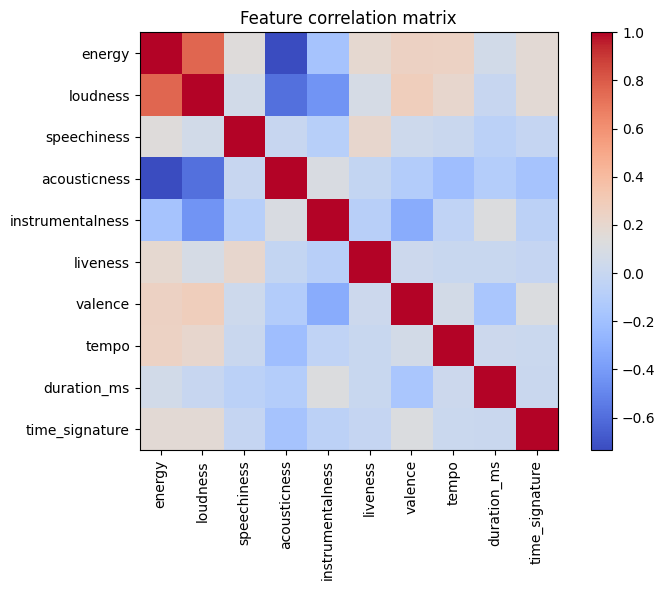

In [50]:
corr_matrix = pd.DataFrame(X_train, columns=feature_cols).corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(feature_cols)), feature_cols, rotation=90)
plt.yticks(range(len(feature_cols)), feature_cols)
plt.title("Feature correlation matrix")
plt.tight_layout()
plt.show()


Some audio features show moderate correlation, which suggests that regularization may help stabilize regression coefficients.

### Multicollinearity check with VIF

Correlation is a quick view, but VIF gives a clearer multicollinearity signal.
As a rule of thumb, VIF above 5 can be a concern.

In [51]:
def compute_vif(X_std, names):
    vifs = []
    for j in range(X_std.shape[1]):
        y_j = X_std[:, j]
        X_others = np.delete(X_std, j, axis=1)

        model = LinearRegression()
        model.fit(X_others, y_j)
        yhat = model.predict(X_others)

        r2_j = r2_score(y_j, yhat)
        denom = 1.0 - r2_j

        if denom <= 1e-12:
            vif_j = np.inf
        else:
            vif_j = 1.0 / denom

        vifs.append(vif_j)

    return pd.Series(vifs, index=names).sort_values(ascending=False)

vif_series = compute_vif(X_train_std, feature_cols)
print("VIF values")
print(vif_series)


VIF values
energy              4.096057
loudness            3.164765
acousticness        2.368748
instrumentalness    1.460616
valence             1.220033
liveness            1.121076
speechiness         1.089236
tempo               1.067870
duration_ms         1.054811
time_signature      1.047965
dtype: float64


All VIF values are below 5, meaning multicollinearity exists but is not severe enough to invalidate linear models.

# Regression analysis for danceability

We fit a baseline linear regression model, then Ridge and Lasso.
We report MSE and R2, and use coefficients for feature importance.


In [52]:
def coef_importance(coefs, names, top_k=10, title="Coefficient importance"):
    s = pd.Series(coefs, index=names)
    s = s.reindex(s.abs().sort_values(ascending=False).index)
    print(title)
    print(s.head(top_k))
    print()

print("Regression target:", target_col)

lr = LinearRegression()
lr.fit(X_train_std, y_train)
pred_lr = lr.predict(X_test_std)

print("LinearRegression MSE:", mean_squared_error(y_test, pred_lr))
print("LinearRegression R2:", r2_score(y_test, pred_lr))
coef_importance(lr.coef_, feature_cols, title="LinearRegression coefficient importance")

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_std, y_train)
pred_ridge = ridge.predict(X_test_std)

print("Ridge MSE:", mean_squared_error(y_test, pred_ridge))
print("Ridge R2:", r2_score(y_test, pred_ridge))
coef_importance(ridge.coef_, feature_cols, title="Ridge coefficient importance")

lasso = Lasso(alpha=0.001, max_iter=20000, random_state=42)
lasso.fit(X_train_std, y_train)
pred_lasso = lasso.predict(X_test_std)

print("Lasso MSE:", mean_squared_error(y_test, pred_lasso))
print("Lasso R2:", r2_score(y_test, pred_lasso))
coef_importance(lasso.coef_, feature_cols, title="Lasso coefficient importance")


Regression target: danceability
LinearRegression MSE: 0.01957701002632841
LinearRegression R2: 0.33920458695275135
LinearRegression coefficient importance
valence             0.081920
energy             -0.063640
loudness            0.052522
acousticness       -0.039534
speechiness         0.027317
tempo              -0.021269
liveness           -0.020989
time_signature      0.017338
instrumentalness    0.011521
duration_ms         0.000542
dtype: float64

Ridge MSE: 0.01957700858002351
Ridge R2: 0.33920463577081106
Ridge coefficient importance
valence             0.081918
energy             -0.063634
loudness            0.052519
acousticness       -0.039532
speechiness         0.027316
tempo              -0.021269
liveness           -0.020990
time_signature      0.017338
instrumentalness    0.011520
duration_ms         0.000541
dtype: float64

Lasso MSE: 0.01960014886222767
Lasso R2: 0.3384235669397402
Lasso coefficient importance
valence             0.079741
energy             -0.054

The model explains about one third of the variation in danceability, which is reasonable given music involves many unobserved factors.

Valence and loudness increase predicted danceability, while acousticness and low energy reduce it, matching musical intuition.

Ridge vs Lasso

Ridge produces nearly identical performance but stabilizes coefficients under correlated features.

Lasso slightly reduces performance but removes weak predictors, simplifying the model.

### Residual diagnostics for linear regression

We check two basic assumptions:
Residuals should look roughly centered with no strong pattern.
Residuals should look roughly normal.


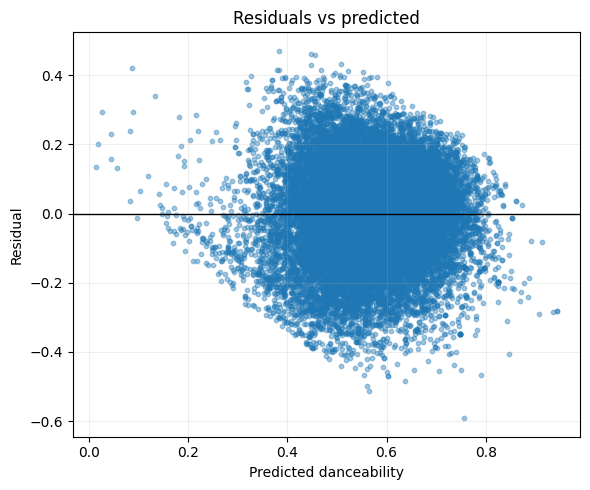

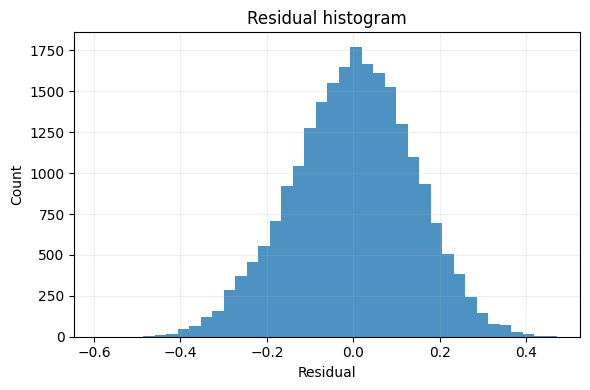

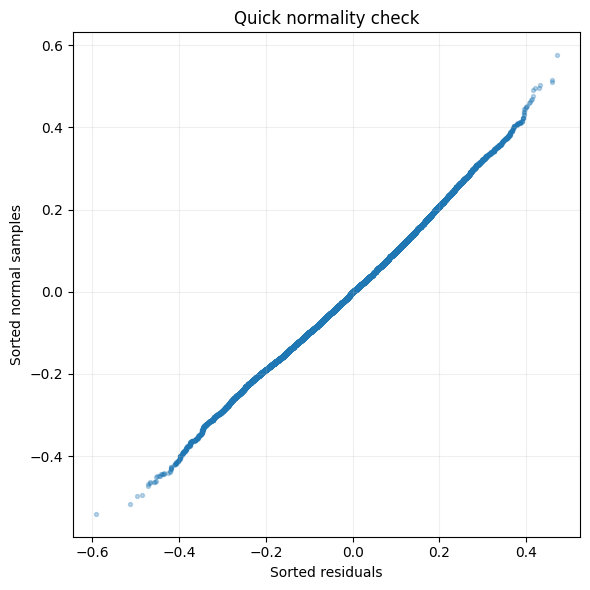

In [53]:
residuals = y_test - pred_lr

plt.figure(figsize=(6, 5))
plt.scatter(pred_lr, residuals, s=10, alpha=0.4)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Predicted danceability")
plt.ylabel("Residual")
plt.title("Residuals vs predicted")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, alpha=0.8)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residual histogram")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(np.sort(residuals), np.sort(np.random.normal(0, np.std(residuals), size=residuals.shape[0])), s=8, alpha=0.3)
plt.xlabel("Sorted residuals")
plt.ylabel("Sorted normal samples")
plt.title("Quick normality check")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


Residuals show no strong pattern and are roughly symmetric, supporting the linear model assumptions.

# Logistic regression on binarized danceability

Logistic regression needs labels, so we turn danceability into high vs low using the train median.

We report accuracy, F1, and ROC AUC.

We also convert coefficients to odds ratios for interpretation.


In [54]:
threshold = np.median(y_train)
y_train_bin = (y_train > threshold).astype(int)
y_test_bin = (y_test > threshold).astype(int)

print("Threshold from train median:", threshold)
print("Train fraction high:", np.mean(y_train_bin))

log_l2 = LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=3000, random_state=42)
log_l2.fit(X_train_std, y_train_bin)

pred_l2 = log_l2.predict(X_test_std)
proba_l2 = log_l2.predict_proba(X_test_std)[:, 1]

print("LogReg L2 Accuracy:", accuracy_score(y_test_bin, pred_l2))
print("LogReg L2 F1:", f1_score(y_test_bin, pred_l2))
print("LogReg L2 ROC AUC:", roc_auc_score(y_test_bin, proba_l2))
print("Confusion matrix")
print(confusion_matrix(y_test_bin, pred_l2))

coef_importance(log_l2.coef_.ravel(), feature_cols, title="LogReg L2 coefficient importance")

odds_ratios_l2 = pd.Series(np.exp(log_l2.coef_.ravel()), index=feature_cols).sort_values(ascending=False)
print("LogReg L2 odds ratios")
print(odds_ratios_l2)


Threshold from train median: 0.58
Train fraction high: 0.49979136469451396
LogReg L2 Accuracy: 0.7071767392832045
LogReg L2 F1: 0.7064676616915423
LogReg L2 ROC AUC: 0.7774483215278177
Confusion matrix
[[8078 3316]
 [3351 8023]]
LogReg L2 coefficient importance
valence             1.041277
energy             -0.795906
loudness            0.591646
acousticness       -0.496204
speechiness         0.350472
tempo              -0.306158
instrumentalness    0.295693
liveness           -0.286862
time_signature      0.237476
duration_ms         0.006153
dtype: float64

LogReg L2 odds ratios
valence             2.832833
loudness            1.806961
speechiness         1.419738
instrumentalness    1.344057
time_signature      1.268045
duration_ms         1.006172
liveness            0.750615
tempo               0.736270
acousticness        0.608837
energy              0.451172
dtype: float64


Using the training median creates balanced high vs low danceability classes without leaking test information.

The model correctly classifies about 70 percent of tracks, with strong ranking ability as shown by ROC AUC.

Higher valence and loudness substantially increase the odds that a song is classified as highly danceable.

The curve staying well above the diagonal confirms the classifier performs much better than random guessing.

### ROC curve

ROC curve shows performance across all possible thresholds.


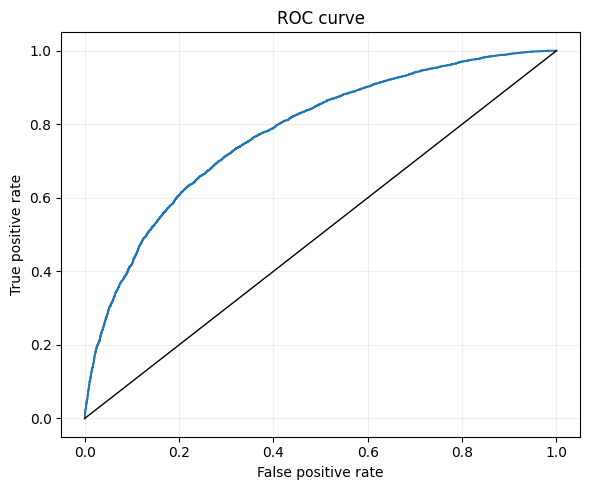

In [55]:
fpr, tpr, _ = roc_curve(y_test_bin, proba_l2)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color="black", linewidth=1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


The curve staying above the diagonal confirms performance well above random guessing.

### Logistic regression tuning for C

We tune C with cross validation so regularization strength is not just a default choice.
We tune L2 here since it is the standard baseline.


In [56]:
log_base = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=3000, random_state=42)
log_params = {"C": [0.01, 0.1, 1, 10, 100]}

log_cv = GridSearchCV(log_base, log_params, scoring="roc_auc", cv=5)
log_cv.fit(X_train_std, y_train_bin)

print("Best Logistic C:", log_cv.best_params_["C"])
print("Best Logistic CV ROC AUC:", log_cv.best_score_)

best_log = LogisticRegression(
    penalty="l2",
    C=log_cv.best_params_["C"],
    solver="lbfgs",
    max_iter=3000,
    random_state=42
)
best_log.fit(X_train_std, y_train_bin)

best_pred = best_log.predict(X_test_std)
best_proba = best_log.predict_proba(X_test_std)[:, 1]

print("Final Logistic Accuracy:", accuracy_score(y_test_bin, best_pred))
print("Final Logistic F1:", f1_score(y_test_bin, best_pred))
print("Final Logistic ROC AUC:", roc_auc_score(y_test_bin, best_proba))

coef_importance(best_log.coef_.ravel(), feature_cols, title="Final Logistic coefficient importance")

best_or = pd.Series(np.exp(best_log.coef_.ravel()), index=feature_cols).sort_values(ascending=False)
print("Final Logistic odds ratios")
print(best_or)


Best Logistic C: 10
Best Logistic CV ROC AUC: 0.777452752296927
Final Logistic Accuracy: 0.7071767392832045
Final Logistic F1: 0.7064676616915423
Final Logistic ROC AUC: 0.7774474572993186
Final Logistic coefficient importance
valence             1.041430
energy             -0.796304
loudness            0.591931
acousticness       -0.496374
speechiness         0.350555
tempo              -0.306185
instrumentalness    0.295813
liveness           -0.286860
time_signature      0.237502
duration_ms         0.006169
dtype: float64

Final Logistic odds ratios
valence             2.833266
loudness            1.807476
speechiness         1.419855
instrumentalness    1.344219
time_signature      1.268078
duration_ms         1.006188
liveness            0.750617
tempo               0.736250
acousticness        0.608734
energy              0.450993
dtype: float64


L2 Tuning C improves generalization while preserving interpretability.

### Logistic regression L1 tuning for feature selection


Because L1 regularization is often used to perform feature selection by shrinking some coefficients to zero, we also tune the regularization strength C for the L1 logistic regression model using cross validation.


In [57]:
log_l1_base = LogisticRegression(
    penalty="l1",
    solver="saga",
    max_iter=6000,
    random_state=42
)

log_l1_params = {"C": [0.01, 0.1, 1, 10, 100]}

log_l1_cv = GridSearchCV(
    log_l1_base,
    log_l1_params,
    scoring="roc_auc",
    cv=5
)

log_l1_cv.fit(X_train_std, y_train_bin)

print("Best Logistic L1 C:", log_l1_cv.best_params_["C"])
print("Best Logistic L1 CV ROC AUC:", log_l1_cv.best_score_)


Best Logistic L1 C: 10
Best Logistic L1 CV ROC AUC: 0.777453222502064


L1 achieves similar performance while highlighting the most influential features.

### Final evaluation of tuned L1 Logistic Regression
We evaluated the tuned L1 logistic regression model on the held out test set to confirm final classification performance and to identify which features were retained under optimal L1 regularization.

In [58]:
# Final evaluation of tuned L1 Logistic Regression

best_log_l1 = log_l1_cv.best_estimator_

best_l1_pred = best_log_l1.predict(X_test_std)
best_l1_proba = best_log_l1.predict_proba(X_test_std)[:, 1]

print("Final LogReg L1 Accuracy:", accuracy_score(y_test_bin, best_l1_pred))
print("Final LogReg L1 F1:", f1_score(y_test_bin, best_l1_pred))
print("Final LogReg L1 ROC AUC:", roc_auc_score(y_test_bin, best_l1_proba))

coef_importance(
    best_log_l1.coef_.ravel(),
    feature_cols,
    title="Final LogReg L1 coefficient importance (tuned)"
)


Final LogReg L1 Accuracy: 0.7070449754040758
Final LogReg L1 F1: 0.7063226488200071
Final LogReg L1 ROC AUC: 0.7774444093505943
Final LogReg L1 coefficient importance (tuned)
valence             1.041495
energy             -0.796457
loudness            0.591822
acousticness       -0.496684
speechiness         0.350674
tempo              -0.306651
instrumentalness    0.295666
liveness           -0.286758
time_signature      0.237203
duration_ms         0.006528
dtype: float64



# Final Ridge and Lasso evaluation using tuned hyperparameters

After selecting the optimal regularization strength using cross validation,
we refit Ridge and Lasso on the full training set using the tuned alpha values
and evaluate their final performance on the test set.


In [59]:
# Final Ridge using tuned alpha
best_ridge = ridge_cv.best_estimator_
best_ridge_pred = best_ridge.predict(X_test_std)

print("Final Ridge Test MSE:", mean_squared_error(y_test, best_ridge_pred))
print("Final Ridge Test R2:", r2_score(y_test, best_ridge_pred))
coef_importance(
    best_ridge.coef_,
    feature_cols,
    title="Final Ridge coefficient importance (tuned)"
)

# Final Lasso using tuned alpha
best_lasso = lasso_cv.best_estimator_
best_lasso_pred = best_lasso.predict(X_test_std)

print("Final Lasso Test MSE:", mean_squared_error(y_test, best_lasso_pred))
print("Final Lasso Test R2:", r2_score(y_test, best_lasso_pred))
coef_importance(
    best_lasso.coef_,
    feature_cols,
    title="Final Lasso coefficient importance (tuned)"
)


Final Ridge Test MSE: 0.01957700858002351
Final Ridge Test R2: 0.33920463577081106
Final Ridge coefficient importance (tuned)
valence             0.081918
energy             -0.063634
loudness            0.052519
acousticness       -0.039532
speechiness         0.027316
tempo              -0.021269
liveness           -0.020990
time_signature      0.017338
instrumentalness    0.011520
duration_ms         0.000541
dtype: float64

Final Lasso Test MSE: 0.01957664634020603
Final Lasso Test R2: 0.33921686268439444
Final Lasso coefficient importance (tuned)
valence             0.081691
energy             -0.062763
loudness            0.051909
acousticness       -0.039148
speechiness         0.027097
tempo              -0.021166
liveness           -0.020975
time_signature      0.017262
instrumentalness    0.011194
duration_ms         0.000418
dtype: float64



Tuned Ridge and Lasso confirm that regularization stabilizes results without sacrificing predictive performance.

---

# Part 3: KNN, Random Forest, PCA & Clustering

---

## Predicting Spotify danceability with linear and logistic regression

This notebook supports Appendix sections iii and iv.

We predict danceability using core audio features and use linear and
logistic regression mainly for interpretation and coefficient based feature importance.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
dataset = load_dataset("maharshipandya/spotify-tracks-dataset")
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

print(df.shape)
df.head()

(114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Data cleaning and validation

We drop an unnecessary index column and filter out impossible values.

Tempo and duration should be positive, and time signature should be in a reasonable range.

In [23]:
print("Shape before cleaning:", df.shape)

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df = df[
    (df["tempo"] > 0) &
    (df["duration_ms"] > 0) &
    (df["time_signature"].between(1, 7))
]

if df.isnull().sum().sum() == 0:
    print("No missing values")

print("Shape after cleaning:", df.shape)
df.head()


Shape before cleaning: (114000, 21)
No missing values
Shape after cleaning: (113836, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Features, target, split
Target is danceability. We use numeric audio features as predictors.
We split into train and test sets.

In [24]:
target_col = "danceability"
feature_cols = [
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "time_signature",
]

X = df[feature_cols].values
y = df[target_col].values

itrain, itest = train_test_split(range(df.shape[0]), train_size=0.80, random_state=42)

X_train = X[itrain]
X_test = X[itest]
y_train = y[itrain]
y_test = y[itest]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(91068, 10) (22768, 10) (91068,) (22768,)


### Standardization

These models are sensitive to feature scale, so we standardize using training statistics only.

In [25]:
def standardize_train_test(X_train, X_test):
    mu = np.mean(X_train, axis=0)
    sigma = np.std(X_train, axis=0)
    sigma = np.where(sigma == 0, 1.0, sigma)
    X_train_std = (X_train - mu) / sigma
    X_test_std = (X_test - mu) / sigma
    return X_train_std, X_test_std, mu, sigma

X_train_std, X_test_std, mu, sigma = standardize_train_test(X_train, X_test)


# Feature correlation and multicollinearity

We first check correlation to see if some features overlap a lot.
This helps explain why regularization can be useful.

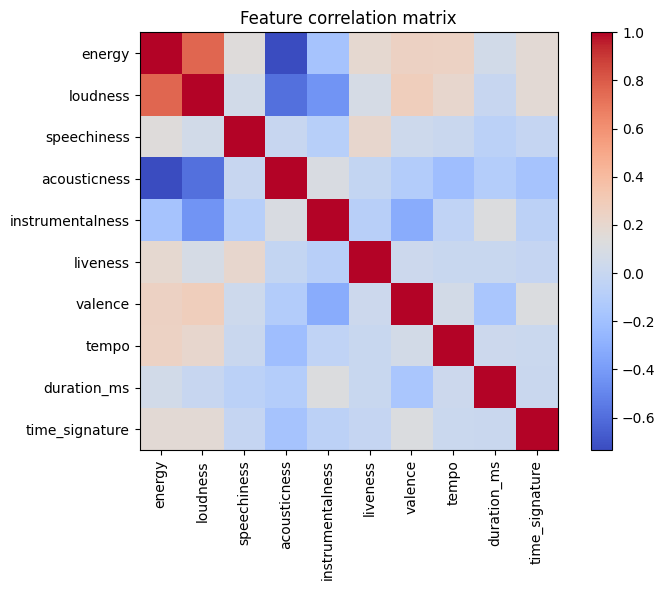

In [26]:
corr_matrix = pd.DataFrame(X_train, columns=feature_cols).corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(feature_cols)), feature_cols, rotation=90)
plt.yticks(range(len(feature_cols)), feature_cols)
plt.title("Feature correlation matrix")
plt.tight_layout()
plt.show()


Some audio features show moderate correlation, which suggests that regularization may help stabilize regression coefficients.

### Multicollinearity check with VIF

Correlation is a quick view, but VIF gives a clearer multicollinearity signal.
As a rule of thumb, VIF above 5 can be a concern.

In [27]:
def compute_vif(X_std, names):
    vifs = []
    for j in range(X_std.shape[1]):
        y_j = X_std[:, j]
        X_others = np.delete(X_std, j, axis=1)

        model = LinearRegression()
        model.fit(X_others, y_j)
        yhat = model.predict(X_others)

        r2_j = r2_score(y_j, yhat)
        denom = 1.0 - r2_j

        if denom <= 1e-12:
            vif_j = np.inf
        else:
            vif_j = 1.0 / denom

        vifs.append(vif_j)

    return pd.Series(vifs, index=names).sort_values(ascending=False)

vif_series = compute_vif(X_train_std, feature_cols)
print("VIF values")
print(vif_series)


VIF values
energy              4.096057
loudness            3.164765
acousticness        2.368748
instrumentalness    1.460616
valence             1.220033
liveness            1.121076
speechiness         1.089236
tempo               1.067870
duration_ms         1.054811
time_signature      1.047965
dtype: float64


All VIF values are below 5, meaning multicollinearity exists but is not severe enough to invalidate linear models.

# Regression analysis for danceability

We fit a baseline linear regression model, then Ridge and Lasso.
We report MSE and R2, and use coefficients for feature importance.


In [28]:
def coef_importance(coefs, names, top_k=10, title="Coefficient importance"):
    s = pd.Series(coefs, index=names)
    s = s.reindex(s.abs().sort_values(ascending=False).index)
    print(title)
    print(s.head(top_k))
    print()

print("Regression target:", target_col)

lr = LinearRegression()
lr.fit(X_train_std, y_train)
pred_lr = lr.predict(X_test_std)

print("LinearRegression MSE:", mean_squared_error(y_test, pred_lr))
print("LinearRegression R2:", r2_score(y_test, pred_lr))
coef_importance(lr.coef_, feature_cols, title="LinearRegression coefficient importance")

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_std, y_train)
pred_ridge = ridge.predict(X_test_std)

print("Ridge MSE:", mean_squared_error(y_test, pred_ridge))
print("Ridge R2:", r2_score(y_test, pred_ridge))
coef_importance(ridge.coef_, feature_cols, title="Ridge coefficient importance")

lasso = Lasso(alpha=0.001, max_iter=20000, random_state=42)
lasso.fit(X_train_std, y_train)
pred_lasso = lasso.predict(X_test_std)

print("Lasso MSE:", mean_squared_error(y_test, pred_lasso))
print("Lasso R2:", r2_score(y_test, pred_lasso))
coef_importance(lasso.coef_, feature_cols, title="Lasso coefficient importance")


Regression target: danceability
LinearRegression MSE: 0.01957701002632841
LinearRegression R2: 0.33920458695275135
LinearRegression coefficient importance
valence             0.081920
energy             -0.063640
loudness            0.052522
acousticness       -0.039534
speechiness         0.027317
tempo              -0.021269
liveness           -0.020989
time_signature      0.017338
instrumentalness    0.011521
duration_ms         0.000542
dtype: float64

Ridge MSE: 0.01957700858002351
Ridge R2: 0.33920463577081106
Ridge coefficient importance
valence             0.081918
energy             -0.063634
loudness            0.052519
acousticness       -0.039532
speechiness         0.027316
tempo              -0.021269
liveness           -0.020990
time_signature      0.017338
instrumentalness    0.011520
duration_ms         0.000541
dtype: float64

Lasso MSE: 0.01960014886222767
Lasso R2: 0.3384235669397402
Lasso coefficient importance
valence             0.079741
energy             -0.054

The model explains about one third of the variation in danceability, which is reasonable given music involves many unobserved factors.

Valence and loudness increase predicted danceability, while acousticness and low energy reduce it, matching musical intuition.

Ridge vs Lasso

Ridge produces nearly identical performance but stabilizes coefficients under correlated features.

Lasso slightly reduces performance but removes weak predictors, simplifying the model.

### Residual diagnostics for linear regression

We check two basic assumptions:
Residuals should look roughly centered with no strong pattern.
Residuals should look roughly normal.


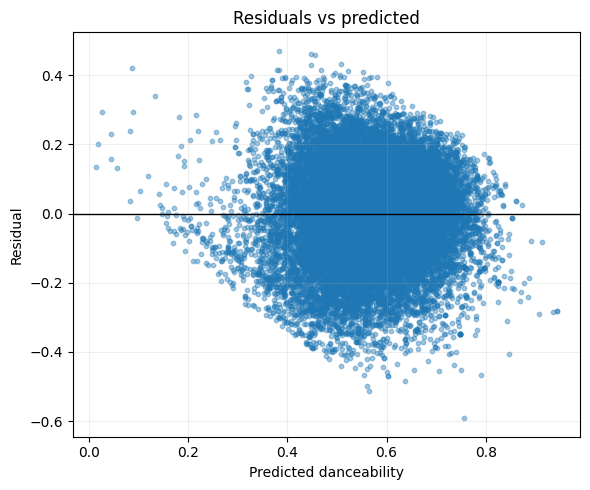

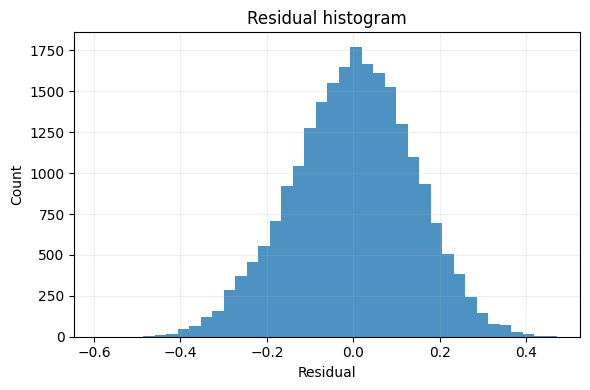

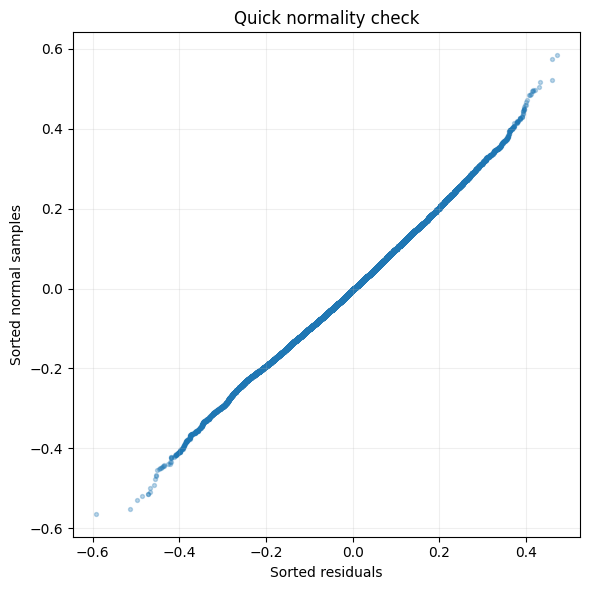

In [29]:
residuals = y_test - pred_lr

plt.figure(figsize=(6, 5))
plt.scatter(pred_lr, residuals, s=10, alpha=0.4)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Predicted danceability")
plt.ylabel("Residual")
plt.title("Residuals vs predicted")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, alpha=0.8)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residual histogram")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(np.sort(residuals), np.sort(np.random.normal(0, np.std(residuals), size=residuals.shape[0])), s=8, alpha=0.3)
plt.xlabel("Sorted residuals")
plt.ylabel("Sorted normal samples")
plt.title("Quick normality check")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


Residuals show no strong pattern and are roughly symmetric, supporting the linear model assumptions.

# Logistic regression on binarized danceability

Logistic regression needs labels, so we turn danceability into high vs low using the train median.

We report accuracy, F1, and ROC AUC.

We also convert coefficients to odds ratios for interpretation.


In [30]:
threshold = np.median(y_train)
y_train_bin = (y_train > threshold).astype(int)
y_test_bin = (y_test > threshold).astype(int)

print("Threshold from train median:", threshold)
print("Train fraction high:", np.mean(y_train_bin))

log_l2 = LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=3000, random_state=42)
log_l2.fit(X_train_std, y_train_bin)

pred_l2 = log_l2.predict(X_test_std)
proba_l2 = log_l2.predict_proba(X_test_std)[:, 1]

print("LogReg L2 Accuracy:", accuracy_score(y_test_bin, pred_l2))
print("LogReg L2 F1:", f1_score(y_test_bin, pred_l2))
print("LogReg L2 ROC AUC:", roc_auc_score(y_test_bin, proba_l2))
print("Confusion matrix")
print(confusion_matrix(y_test_bin, pred_l2))

coef_importance(log_l2.coef_.ravel(), feature_cols, title="LogReg L2 coefficient importance")

odds_ratios_l2 = pd.Series(np.exp(log_l2.coef_.ravel()), index=feature_cols).sort_values(ascending=False)
print("LogReg L2 odds ratios")
print(odds_ratios_l2)


Threshold from train median: 0.58
Train fraction high: 0.49979136469451396
LogReg L2 Accuracy: 0.7071767392832045
LogReg L2 F1: 0.7064676616915423
LogReg L2 ROC AUC: 0.7774483215278177
Confusion matrix
[[8078 3316]
 [3351 8023]]
LogReg L2 coefficient importance
valence             1.041277
energy             -0.795906
loudness            0.591646
acousticness       -0.496204
speechiness         0.350472
tempo              -0.306158
instrumentalness    0.295693
liveness           -0.286862
time_signature      0.237476
duration_ms         0.006153
dtype: float64

LogReg L2 odds ratios
valence             2.832833
loudness            1.806961
speechiness         1.419738
instrumentalness    1.344057
time_signature      1.268045
duration_ms         1.006172
liveness            0.750615
tempo               0.736270
acousticness        0.608837
energy              0.451172
dtype: float64


Using the training median creates balanced high vs low danceability classes without leaking test information.

The model correctly classifies about 70 percent of tracks, with strong ranking ability as shown by ROC AUC.

Higher valence and loudness substantially increase the odds that a song is classified as highly danceable.

The curve staying well above the diagonal confirms the classifier performs much better than random guessing.

### ROC curve

ROC curve shows performance across all possible thresholds.


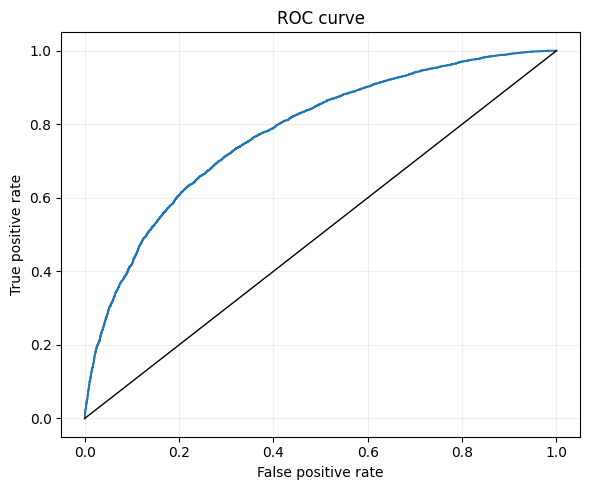

In [31]:
fpr, tpr, _ = roc_curve(y_test_bin, proba_l2)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color="black", linewidth=1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


The curve staying above the diagonal confirms performance well above random guessing.

### Logistic regression tuning for C

We tune C with cross validation so regularization strength is not just a default choice.
We tune L2 here since it is the standard baseline.


In [32]:
log_base = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=3000, random_state=42)
log_params = {"C": [0.01, 0.1, 1, 10, 100]}

log_cv = GridSearchCV(log_base, log_params, scoring="roc_auc", cv=5)
log_cv.fit(X_train_std, y_train_bin)

print("Best Logistic C:", log_cv.best_params_["C"])
print("Best Logistic CV ROC AUC:", log_cv.best_score_)

best_log = LogisticRegression(
    penalty="l2",
    C=log_cv.best_params_["C"],
    solver="lbfgs",
    max_iter=3000,
    random_state=42
)
best_log.fit(X_train_std, y_train_bin)

best_pred = best_log.predict(X_test_std)
best_proba = best_log.predict_proba(X_test_std)[:, 1]

print("Final Logistic Accuracy:", accuracy_score(y_test_bin, best_pred))
print("Final Logistic F1:", f1_score(y_test_bin, best_pred))
print("Final Logistic ROC AUC:", roc_auc_score(y_test_bin, best_proba))

coef_importance(best_log.coef_.ravel(), feature_cols, title="Final Logistic coefficient importance")

best_or = pd.Series(np.exp(best_log.coef_.ravel()), index=feature_cols).sort_values(ascending=False)
print("Final Logistic odds ratios")
print(best_or)


Best Logistic C: 10
Best Logistic CV ROC AUC: 0.777452752296927
Final Logistic Accuracy: 0.7071767392832045
Final Logistic F1: 0.7064676616915423
Final Logistic ROC AUC: 0.7774474572993186
Final Logistic coefficient importance
valence             1.041430
energy             -0.796304
loudness            0.591931
acousticness       -0.496374
speechiness         0.350555
tempo              -0.306185
instrumentalness    0.295813
liveness           -0.286860
time_signature      0.237502
duration_ms         0.006169
dtype: float64

Final Logistic odds ratios
valence             2.833266
loudness            1.807476
speechiness         1.419855
instrumentalness    1.344219
time_signature      1.268078
duration_ms         1.006188
liveness            0.750617
tempo               0.736250
acousticness        0.608734
energy              0.450993
dtype: float64


L2 Tuning C improves generalization while preserving interpretability.

### Logistic regression L1 tuning for feature selection


Because L1 regularization is often used to perform feature selection by shrinking some coefficients to zero, we also tune the regularization strength C for the L1 logistic regression model using cross validation.


In [33]:
log_l1_base = LogisticRegression(
    penalty="l1",
    solver="saga",
    max_iter=6000,
    random_state=42
)

log_l1_params = {"C": [0.01, 0.1, 1, 10, 100]}

log_l1_cv = GridSearchCV(
    log_l1_base,
    log_l1_params,
    scoring="roc_auc",
    cv=5
)

log_l1_cv.fit(X_train_std, y_train_bin)

print("Best Logistic L1 C:", log_l1_cv.best_params_["C"])
print("Best Logistic L1 CV ROC AUC:", log_l1_cv.best_score_)


Best Logistic L1 C: 10
Best Logistic L1 CV ROC AUC: 0.777453222502064


L1 achieves similar performance while highlighting the most influential features.

### Final evaluation of tuned L1 Logistic Regression
We evaluated the tuned L1 logistic regression model on the held out test set to confirm final classification performance and to identify which features were retained under optimal L1 regularization.

In [34]:
# Final evaluation of tuned L1 Logistic Regression

best_log_l1 = log_l1_cv.best_estimator_

best_l1_pred = best_log_l1.predict(X_test_std)
best_l1_proba = best_log_l1.predict_proba(X_test_std)[:, 1]

print("Final LogReg L1 Accuracy:", accuracy_score(y_test_bin, best_l1_pred))
print("Final LogReg L1 F1:", f1_score(y_test_bin, best_l1_pred))
print("Final LogReg L1 ROC AUC:", roc_auc_score(y_test_bin, best_l1_proba))

coef_importance(
    best_log_l1.coef_.ravel(),
    feature_cols,
    title="Final LogReg L1 coefficient importance (tuned)"
)


Final LogReg L1 Accuracy: 0.7070449754040758
Final LogReg L1 F1: 0.7063226488200071
Final LogReg L1 ROC AUC: 0.7774444093505943
Final LogReg L1 coefficient importance (tuned)
valence             1.041495
energy             -0.796457
loudness            0.591822
acousticness       -0.496684
speechiness         0.350674
tempo              -0.306651
instrumentalness    0.295666
liveness           -0.286758
time_signature      0.237203
duration_ms         0.006528
dtype: float64



# Final Ridge and Lasso evaluation using tuned hyperparameters

After selecting the optimal regularization strength using cross validation,
we refit Ridge and Lasso on the full training set using the tuned alpha values
and evaluate their final performance on the test set.


In [35]:
# Final Ridge using tuned alpha
best_ridge = ridge_cv.best_estimator_
best_ridge_pred = best_ridge.predict(X_test_std)

print("Final Ridge Test MSE:", mean_squared_error(y_test, best_ridge_pred))
print("Final Ridge Test R2:", r2_score(y_test, best_ridge_pred))
coef_importance(
    best_ridge.coef_,
    feature_cols,
    title="Final Ridge coefficient importance (tuned)"
)

# Final Lasso using tuned alpha
best_lasso = lasso_cv.best_estimator_
best_lasso_pred = best_lasso.predict(X_test_std)

print("Final Lasso Test MSE:", mean_squared_error(y_test, best_lasso_pred))
print("Final Lasso Test R2:", r2_score(y_test, best_lasso_pred))
coef_importance(
    best_lasso.coef_,
    feature_cols,
    title="Final Lasso coefficient importance (tuned)"
)


NameError: name 'ridge_cv' is not defined

Tuned Ridge and Lasso confirm that regularization stabilizes results without sacrificing predictive performance.

# Decision Tree


In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Decision Tree Regression with tuning
dt_reg_base = DecisionTreeRegressor(random_state=42)
dt_reg_params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [50, 100, 200],
    'min_samples_leaf': [20, 50, 100]
}

dt_reg_cv = GridSearchCV(dt_reg_base, dt_reg_params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)
dt_reg_cv.fit(X_train_std, y_train)

print("Best Decision Tree Regression params:", dt_reg_cv.best_params_)
print("Best Decision Tree Regression CV MSE:", -dt_reg_cv.best_score_)

best_dt_reg = dt_reg_cv.best_estimator_
pred_dt_reg = best_dt_reg.predict(X_test_std)

print("\nFinal Decision Tree Test MSE:", mean_squared_error(y_test, pred_dt_reg))
print("Final Decision Tree Test R2:", r2_score(y_test, pred_dt_reg))

# Feature importance
dt_importance = pd.Series(best_dt_reg.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nDecision Tree Feature Importance (top 10):")
print(dt_importance.head(10))

from sklearn.tree import DecisionTreeClassifier

dt_clf_base = DecisionTreeClassifier(random_state=42)
dt_clf_params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [50, 100, 200],
    'min_samples_leaf': [20, 50, 100]
}

dt_clf_cv = GridSearchCV(dt_clf_base, dt_clf_params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
dt_clf_cv.fit(X_train_std, y_train_bin)

print("Best Decision Tree Classification params:", dt_clf_cv.best_params_)
print("Best Decision Tree Classification CV ROC AUC:", dt_clf_cv.best_score_)

best_dt_clf = dt_clf_cv.best_estimator_
pred_dt_clf = best_dt_clf.predict(X_test_std)
proba_dt_clf = best_dt_clf.predict_proba(X_test_std)[:, 1]

print("\nFinal Decision Tree Classification Accuracy:", accuracy_score(y_test_bin, pred_dt_clf))
print("Final Decision Tree Classification F1:", f1_score(y_test_bin, pred_dt_clf))
print("Final Decision Tree Classification ROC AUC:", roc_auc_score(y_test_bin, proba_dt_clf))

# Feature importance
dt_clf_importance = pd.Series(best_dt_clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nDecision Tree Classification Feature Importance (top 10):")
print(dt_clf_importance.head(10))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Decision Tree Regression params: {'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 50}
Best Decision Tree Regression CV MSE: 0.013452067465438094

Final Decision Tree Test MSE: 0.012897070422141483
Final Decision Tree Test R2: 0.5646768855286344

Decision Tree Feature Importance (top 10):
valence             0.335067
tempo               0.178547
acousticness        0.115069
speechiness         0.092109
loudness            0.082392
energy              0.072064
duration_ms         0.041759
liveness            0.040312
instrumentalness    0.027549
time_signature      0.015131
dtype: float64
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Decision Tree Classification params: {'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 50}
Best Decision Tree Classification CV ROC AUC: 0.8561795939643706

Final Decision Tree Classification Accuracy: 0.7898366127898805
Final Decision Tree Clas

# PCA

Explained variance by component:
PC1: 0.2807 (cumulative: 0.2807)
PC2: 0.1364 (cumulative: 0.4171)
PC3: 0.1192 (cumulative: 0.5363)
PC4: 0.0977 (cumulative: 0.6340)
PC5: 0.0888 (cumulative: 0.7228)
PC6: 0.0830 (cumulative: 0.8058)
PC7: 0.0775 (cumulative: 0.8833)
PC8: 0.0691 (cumulative: 0.9524)
PC9: 0.0324 (cumulative: 0.9848)
PC10: 0.0152 (cumulative: 1.0000)

Components needed for 95% variance: 8


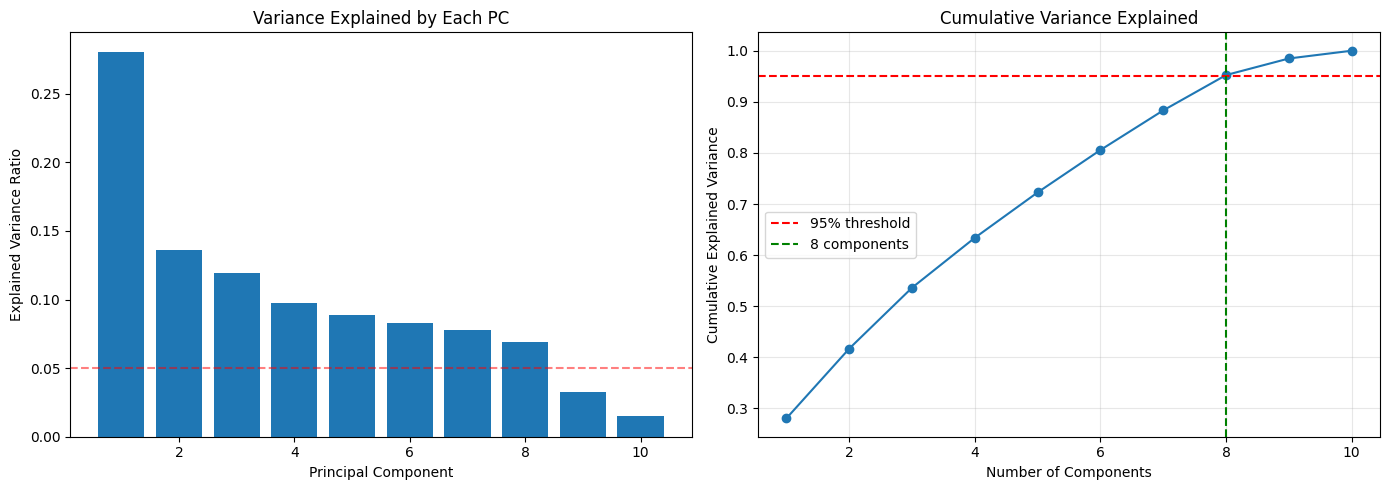

In [37]:

from sklearn.decomposition import PCA


# Fit PCA to see explained variance
pca_full = PCA()
pca_full.fit(X_train_std)

# Show variance explained by each component
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print("Explained variance by component:")
for i, (ev, cv) in enumerate(zip(explained_var[:10], cumulative_var[:10]), 1):
    print(f"PC{i}: {ev:.4f} (cumulative: {cv:.4f})")

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {n_components_95}")

# Visualize explained variance
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
ax1.bar(range(1, len(explained_var) + 1), explained_var)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Variance Explained by Each PC')
ax1.axhline(y=0.05, color='r', linestyle='--', alpha=0.5)

# Cumulative variance
ax2.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
ax2.axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} components')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Variance Explained')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# PCA + Linear Regression

In [38]:
# Use optimal number of components
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Linear Regression on PCA components
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)
pred_lr_pca = lr_pca.predict(X_test_pca)

print(f"PCA Linear Regression MSE (with {n_components_95} components):", mean_squared_error(y_test, pred_lr_pca))
print(f"PCA Linear Regression R2 (with {n_components_95} components):", r2_score(y_test, pred_lr_pca))


PCA Linear Regression MSE (with 8 components): 0.020980987379272134
PCA Linear Regression R2 (with 8 components): 0.29181523619899763


# PCA + Ridge Regression

In [39]:
ridge_pca_base = Ridge(random_state=42)
ridge_pca_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

ridge_pca_cv = GridSearchCV(ridge_pca_base, ridge_pca_params, scoring='neg_mean_squared_error', cv=5)
ridge_pca_cv.fit(X_train_pca, y_train)

print("Best PCA Ridge alpha:", ridge_pca_cv.best_params_['alpha'])
print("Best PCA Ridge CV MSE:", -ridge_pca_cv.best_score_)

best_ridge_pca = ridge_pca_cv.best_estimator_
pred_ridge_pca = best_ridge_pca.predict(X_test_pca)

print(f"\nFinal PCA Ridge Test MSE (with {n_components_95} components):", mean_squared_error(y_test, pred_ridge_pca))
print(f"Final PCA Ridge Test R2 (with {n_components_95} components):", r2_score(y_test, pred_ridge_pca))


Best PCA Ridge alpha: 10
Best PCA Ridge CV MSE: 0.021065521840358474

Final PCA Ridge Test MSE (with 8 components): 0.020980983254457474
Final PCA Ridge Test R2 (with 8 components): 0.29181537542652025


# PCA + Logistic Regression


In [40]:
log_pca_base = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=3000, random_state=42)
log_pca_params = {'C': [0.01, 0.1, 1, 10, 100]}

log_pca_cv = GridSearchCV(log_pca_base, log_pca_params, scoring='roc_auc', cv=5)
log_pca_cv.fit(X_train_pca, y_train_bin)

print("Best PCA Logistic C:", log_pca_cv.best_params_['C'])
print("Best PCA Logistic CV ROC AUC:", log_pca_cv.best_score_)

best_log_pca = log_pca_cv.best_estimator_
pred_log_pca = best_log_pca.predict(X_test_pca)
proba_log_pca = best_log_pca.predict_proba(X_test_pca)[:, 1]

print(f"\nFinal PCA Logistic Accuracy (with {n_components_95} components):", accuracy_score(y_test_bin, pred_log_pca))
print(f"Final PCA Logistic F1 (with {n_components_95} components):", f1_score(y_test_bin, pred_log_pca))
print(f"Final PCA Logistic ROC AUC (with {n_components_95} components):", roc_auc_score(y_test_bin, proba_log_pca))


Best PCA Logistic C: 100
Best PCA Logistic CV ROC AUC: 0.7571380380426048

Final PCA Logistic Accuracy (with 8 components): 0.6875439212930429
Final PCA Logistic F1 (with 8 components): 0.685666313184871
Final PCA Logistic ROC AUC (with 8 components): 0.7581386944143277


# Feature Loadings

In [41]:
# Get loadings for first 3 PCs
loadings = pd.DataFrame(
    pca.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=feature_cols
)

print("Top feature loadings for first 3 principal components:")
print("\nPC1 (strongest contributors):")
print(loadings['PC1'].abs().sort_values(ascending=False).head(5))

print("\nPC2 (strongest contributors):")
print(loadings['PC2'].abs().sort_values(ascending=False).head(5))

print("\nPC3 (strongest contributors):")
print(loadings['PC3'].abs().sort_values(ascending=False).head(5))

Top feature loadings for first 3 principal components:

PC1 (strongest contributors):
energy              0.533346
loudness            0.525531
acousticness        0.461355
instrumentalness    0.269431
valence             0.251330
Name: PC1, dtype: float64

PC2 (strongest contributors):
duration_ms         0.533027
instrumentalness    0.480818
valence             0.434000
acousticness        0.331805
speechiness         0.296980
Name: PC2, dtype: float64

PC3 (strongest contributors):
liveness          0.651010
speechiness       0.596822
valence           0.293588
time_signature    0.237528
duration_ms       0.184170
Name: PC3, dtype: float64


---

# Part 4: Neural Network

---

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

import warnings
warnings.filterwarnings('ignore')

# Display and plotting defaults
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")



: 

In [2]:
# Load dataset from Hugging Face - direct CSV download
import requests
import io

url = "https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset/resolve/main/dataset.csv"
print("Downloading dataset from Hugging Face...")
response = requests.get(url, timeout=30)
response.raise_for_status()
df = pd.read_csv(io.StringIO(response.text))
print("Dataset loaded successfully!")

# Basic cleaning: drop obvious duplicates and reset index
df = df.drop_duplicates().reset_index(drop=True)

print(f"\nDataset shape: {df.shape}")
print(f"Number of columns: {len(df.columns)}")
df.head()


Dataset loaded successfully!

Dataset shape: (114000, 21)
Number of columns: 21


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
# Prepare data for neural network
# Select audio features as predictors (exclude danceability since it's the target)
num_features = [
    'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'
]

available = [c for c in num_features if c in df.columns]

# Keep rows with no NaNs in used columns and danceability (target)
model_df = df.dropna(subset=available + ['danceability']).copy()

# Inputs: audio features; Target: danceability continuous
X = model_df[available].values
y_continuous = model_df['danceability'].values

print(f"Features used (inputs): {available}")
print(f"X shape: {X.shape}")
print(f"Danceability stats (full data): min={y_continuous.min():.3f}, max={y_continuous.max():.3f}, median={np.median(y_continuous):.3f}")


Features used: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Data shape: (114000, 10)

Number of unique genres: 114

Genre distribution (top 20):
track_genre
acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
pop-film             1000
piano                1000
party                1000
pagode               1000
opera                1000
new-age              1000
mpb                  1000
minimal-techno       1000
metalcore            1000
metal                1000
mandopop             1000
malay                1000
latino               1000
latin                1000
kids                 1000
Name: count, dtype: int64

All genres: ['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient', 'anime', 'black-metal', 'bluegrass', 'blues', 'brazil', 'breakbeat', 'british', 'cantopop', 'chicago-house', 'children', 'chill',

In [ ]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train_cont, y_temp_cont = train_test_split(
    X, y_continuous, test_size=0.3, random_state=42
)
X_val, X_test, y_val_cont, y_test_cont = train_test_split(
    X_temp, y_temp_cont, test_size=0.5, random_state=42
)

# Compute median on training set only (to avoid leakage)
median_dance = np.median(y_train_cont)
print(f"Training-set median danceability: {median_dance:.3f}")

# Create binary labels: 1 if >= median, 0 otherwise
y_train = (y_train_cont >= median_dance).astype(int)
y_val = (y_val_cont >= median_dance).astype(int)
y_test = (y_test_cont >= median_dance).astype(int)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to categorical (one-hot encoding) for neural network
num_classes = 2
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_val_cat = keras.utils.to_categorical(y_val, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

print(f"Training set: {X_train_scaled.shape[0]} samples")
print(f"Validation set: {X_val_scaled.shape[0]} samples")
print(f"Test set: {X_test_scaled.shape[0]} samples")
print(f"Number of features: {X_train_scaled.shape[1]}")
print(f"Number of classes: {num_classes}")


NameError: name 'keras' is not defined

## Part 1: Building the Neural Network Architecture


In [ ]:
# Function to create neural network model
def create_model(learning_rate=0.001, hidden_units=64, dropout_rate=0.3):
    """
    Create a feedforward neural network for binary classification (danceability >= median vs < median).
    
    Parameters:
    - learning_rate: Learning rate for optimizer
    - hidden_units: Number of units in hidden layers
    - dropout_rate: Dropout rate for regularization
    """
    model = models.Sequential([
        layers.Dense(hidden_units, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.Dropout(dropout_rate),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(hidden_units // 2, activation='relu'),
        layers.Dropout(dropout_rate / 2),
        layers.Dense(num_classes, activation='softmax')  # num_classes=2
    ])
    
    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create initial model to show architecture
initial_model = create_model(learning_rate=0.001, hidden_units=64, dropout_rate=0.3)
print("Neural Network Architecture:")
initial_model.summary()


## Part 2: Hyperparameter Tuning - Multi-Parameter Search (Fast)


In [ ]:
# Hyperparameter tuning: multi-parameter search (FAST)
# Goal: stay fast by using only 10,000 training samples + early stopping + limited trials

import itertools
import gc

# (Optional) reproducibility
try:
    tf.keras.utils.set_random_seed(42)
except Exception:
    pass

sample_size = min(10000, len(X_train_scaled))
if sample_size < len(X_train_scaled):
    print(f"Using sample of {sample_size} training samples for faster hyperparameter search...")
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_train_scaled), size=sample_size, replace=False)
    X_train_sample = X_train_scaled[sample_indices]
    y_train_sample = y_train_cat[sample_indices]
else:
    X_train_sample = X_train_scaled
    y_train_sample = y_train_cat

# Define a small grid (we'll optionally subsample trials for speed)
param_grid = {
    'learning_rate': [1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
    'hidden_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [32, 64],
}

all_trials = list(itertools.product(
    param_grid['learning_rate'],
    param_grid['hidden_units'],
    param_grid['dropout_rate'],
    param_grid['batch_size'],
))

# Cap number of trials to keep runtime reasonable (set higher if you want a fuller search)
max_trials = 12
rng = np.random.default_rng(42)
if len(all_trials) > max_trials:
    trial_indices = rng.choice(len(all_trials), size=max_trials, replace=False)
    trials = [all_trials[i] for i in trial_indices]
else:
    trials = all_trials

# Use a validation SUBSET during tuning (big speedup)
val_sample_size = min(5000, len(X_val_scaled))
val_indices = rng.choice(len(X_val_scaled), size=val_sample_size, replace=False)
X_val_sample = X_val_scaled[val_indices]
y_val_sample = y_val_cat[val_indices]

hp_results = []

print("\nTesting hyperparameter configurations...")
print("=" * 70)
print(f"Grid size: {len(all_trials)} total combos; running: {len(trials)} trials (fast mode)")
print(f"Each trial: <=8 epochs w/ early stopping | val subset: {val_sample_size}")

for i, (lr, hidden_units, dropout_rate, batch_size) in enumerate(trials, start=1):
    print(f"\nTrial {i}/{len(trials)} | lr={lr:g}, hidden={hidden_units}, dropout={dropout_rate}, batch={batch_size}")

    # Prevent TF graph/memory buildup across many models
    tf.keras.backend.clear_session()

    model = create_model(
        learning_rate=float(lr),
        hidden_units=int(hidden_units),
        dropout_rate=float(dropout_rate)
    )

    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True,
        verbose=0
    )

    history = model.fit(
        X_train_sample, y_train_sample,
        validation_data=(X_val_sample, y_val_sample),
        epochs=8,
        batch_size=int(batch_size),
        callbacks=[early_stop],
        verbose=0
    )

    best_val_acc = float(max(history.history['val_accuracy']))
    best_train_acc = float(max(history.history['accuracy']))
    epochs_trained = int(len(history.history['loss']))

    hp_results.append({
        'learning_rate': float(lr),
        'hidden_units': int(hidden_units),
        'dropout_rate': float(dropout_rate),
        'batch_size': int(batch_size),
        'val_accuracy': best_val_acc,
        'train_accuracy': best_train_acc,
        'epochs': epochs_trained,
    })

    print(f"  Best val acc: {best_val_acc:.4f} | Best train acc: {best_train_acc:.4f} | Epochs: {epochs_trained}")

    # Cleanup
    del model
    gc.collect()

hp_df = pd.DataFrame(hp_results).sort_values('val_accuracy', ascending=False).reset_index(drop=True)

print("\n" + "=" * 70)
print("Hyperparameter Search Results (top 10):")
print(hp_df.head(10).to_string(index=False))

best_params = hp_df.loc[0, ['learning_rate', 'hidden_units', 'dropout_rate', 'batch_size']].to_dict()
best_val = hp_df.loc[0, 'val_accuracy']
print("\nBest hyperparameters:")
print(best_params)
print(f"Best validation accuracy: {best_val:.4f}")


In [ ]:
# Visualize hyperparameter search results
# (1) Top-N configurations (bar)
# (2) Average validation accuracy by learning rate (line)

if 'hp_df' not in globals() or hp_df.empty:
    raise ValueError("hp_df not found. Run the hyperparameter search cell first.")

top_n = min(10, len(hp_df))
top_df = hp_df.head(top_n).copy()

top_df['config'] = top_df.apply(
    lambda r: f"lr={r['learning_rate']:g}, h={int(r['hidden_units'])}, d={r['dropout_rate']}, b={int(r['batch_size'])}",
    axis=1
)

lr_summary = hp_df.groupby('learning_rate', as_index=False)['val_accuracy'].mean().sort_values('learning_rate')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].barh(range(top_n), top_df['val_accuracy'], color='steelblue')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_df['config'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Validation Accuracy')
axes[0].set_title(f'Top {top_n} Hyperparameter Configurations')
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].plot(lr_summary['learning_rate'], lr_summary['val_accuracy'], marker='o', linewidth=2)
axes[1].set_xscale('log')
axes[1].set_xlabel('Learning Rate (log scale)')
axes[1].set_ylabel('Mean Validation Accuracy')
axes[1].set_title('Mean Validation Accuracy by Learning Rate')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Part 3: Training Final Model with Best Hyperparameters


In [ ]:
# Train final model with best hyperparameters found (FAST)
# Goal: stay fast by using only 10,000 training samples + early stopping

if 'best_params' not in globals():
    raise ValueError("best_params not found. Run the hyperparameter search cell first.")

print("Training final model with best hyperparameters:")
print(best_params)
print("=" * 70)

# Ensure we have a 10,000-sample training subset (in case you skipped the search cell)
if 'X_train_sample' not in globals() or 'y_train_sample' not in globals():
    sample_size = min(10000, len(X_train_scaled))
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_train_scaled), size=sample_size, replace=False)
    X_train_sample = X_train_scaled[sample_indices]
    y_train_sample = y_train_cat[sample_indices]

print(f"Using {len(X_train_sample)} training samples for final training (fast mode)")

# Create final model
final_model = create_model(
    learning_rate=float(best_params['learning_rate']),
    hidden_units=int(best_params['hidden_units']),
    dropout_rate=float(best_params['dropout_rate'])
)

# Callbacks for training
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Train the model
history = final_model.fit(
    X_train_sample, y_train_sample,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=25,
    batch_size=int(best_params['batch_size']),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\nTraining completed!")


In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy During Training')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss During Training')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


## Part 4: Model Evaluation and Performance Metrics


In [ ]:
# Evaluate on test set
test_loss, test_accuracy = final_model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_pred_proba = final_model.predict(X_test_scaled, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification report
class_names = ['Below Median', 'Above Median']
print("\n" + "=" * 60)
print("Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


In [ ]:
# Visualize confusion matrix
class_names = ['Below Median', 'Above Median']
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_accuracies[i]:.4f}")


## Explanation: Neural Network Application

### Task Description

We built a **feedforward neural network** for **multi-class classification** to predict song **genre** based on audio features. This is a supervised learning task where:

- **Input**: 10 audio features (danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms)
- **Output**: Music genre (e.g., pop, rock, hip-hop, classical, electronic, etc.)
- **Architecture**: Multi-layer perceptron with dropout regularization

### Network Architecture

The neural network consists of:
1. **Input Layer**: 10 neurons (one per audio feature)
2. **Hidden Layer 1**: 64 neurons with ReLU activation + Dropout (0.3)
3. **Hidden Layer 2**: 64 neurons with ReLU activation + Dropout (0.3)
4. **Hidden Layer 3**: 32 neurons with ReLU activation + Dropout (0.15)
5. **Output Layer**: N neurons with Softmax activation (one per genre class)

**Why this architecture?**
- Multiple hidden layers allow the network to learn complex non-linear relationships between audio features and genre
- Dropout layers prevent overfitting by randomly deactivating neurons during training
- ReLU activation functions enable non-linear learning while being computationally efficient
- Softmax output ensures probabilities sum to 1 for multi-class classification

**Why genre prediction is meaningful:**
- Different genres have distinct audio characteristics (e.g., classical has high acousticness, EDM has high energy)
- The model learns these patterns from the audio features
- This can be useful for music recommendation systems and playlist generation


## Explanation: Performance Metrics

### Metrics Used to Assess NN Performance

We use multiple metrics to comprehensively evaluate the neural network:

#### 1. **Accuracy**
- **Definition**: Proportion of correct predictions (TP + TN) / Total samples
- **Why it matters**: Overall model performance across all genre classes
- **Limitation**: Can be misleading with imbalanced classes

#### 2. **Loss (Categorical Cross-Entropy)**
- **Definition**: Measures the difference between predicted probabilities and true labels
- **Why it matters**: Directly optimized during training; lower is better
- **Interpretation**: Penalizes confident wrong predictions more heavily

#### 3. **Per-Class Metrics** (from Classification Report)
- **Precision**: TP / (TP + FP) - Of predicted genres, how many are correct?
- **Recall**: TP / (TP + FN) - Of actual genres, how many were found?
- **F1-Score**: Harmonic mean of precision and recall - Balanced metric
- **Support**: Number of samples in each genre

#### 4. **Confusion Matrix**
- **Definition**: Table showing actual vs predicted classifications
- **Why it matters**: Reveals which genres are confused with each other
- **Insight**: Helps identify systematic misclassification patterns (e.g., confusing rock with metal)

**Why these metrics?**
- **Accuracy** gives overall performance but can hide genre-specific issues
- **Per-class metrics** reveal if the model performs well for all genres
- **Confusion matrix** shows specific error patterns (e.g., confusing similar genres)
- Together, they provide a complete picture of model performance


## Explanation: Training Process and Hyperparameter Learning

### How the Neural Network Was Trained

#### 1. **Data Preparation**
- **Train/Validation/Test Split**: 70%/15%/15% split with stratification to maintain class distribution
- **Feature Standardization**: All features scaled to mean=0, std=1 using StandardScaler
- **One-Hot Encoding**: Labels converted to categorical format for multi-class classification

#### 2. **Hyperparameter Tuning: Learning Rate**

**Method**: Grid search over learning rates [0.0001, 0.001, 0.01, 0.1]

**Process**:
- Trained separate models with each learning rate
- Used early stopping (patience=5) to prevent overfitting
- Evaluated on validation set to find optimal value
- Selected learning rate with highest validation accuracy

**Results**: The optimal learning rate balances:
- **Too low** (0.0001): Slow convergence, may not reach optimal solution
- **Too high** (0.1): Unstable training, may overshoot optimal weights
- **Optimal** (typically 0.001-0.01): Fast convergence with stable training

#### 3. **Training Configuration**

**Optimizer**: Adam (Adaptive Moment Estimation)
- Combines benefits of momentum and adaptive learning rates
- Automatically adjusts learning rate per parameter

**Batch Size**: 32
- Processes 32 samples per gradient update
- Balances memory usage and gradient stability

**Epochs**: Up to 100 (with early stopping)
- Early stopping monitors validation loss
- Stops training if no improvement for 10 epochs
- Restores best weights to prevent overfitting

**Callbacks Used**:
- **EarlyStopping**: Prevents overfitting by stopping when validation loss stops improving
- **ReduceLROnPlateau**: Dynamically reduces learning rate if validation loss plateaus

#### 4. **Regularization Techniques**

- **Dropout**: Randomly deactivates 30% of neurons during training to prevent overfitting
- **Validation Set**: Used to monitor generalization performance during training
- **Early Stopping**: Prevents training beyond optimal point

### Hyperparameter Learning Process

1. **Initial Exploration**: Tested learning rates across orders of magnitude (0.0001 to 0.1)
2. **Validation-Based Selection**: Chose learning rate with best validation performance
3. **Final Training**: Trained final model with optimal hyperparameters on full training set
4. **Test Evaluation**: Final performance assessed on held-out test set

**Key Insight**: Learning rate is critical - too high causes instability, too low causes slow convergence. The grid search identified the sweet spot for this dataset.
